In [37]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 21 16:14:20 2023

@author: poojap

This program will combine transformed proteomic data and the output of the
spatial proteomic analysis with modules specified. The entrez ID and module
membership will also be detailed.

"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)


In [25]:
gene_analyzing = "SNCA"

print("current directory: ", currdir)

transformedfile = f"LOPIT_{gene_analyzing}_young_Transformed.csv"
module_results_file = f"{gene_analyzing}-TMT-Module-Results.xlsx"

# CHANGE TO YOUR VARIABLES
wildtype = "WildType"
mutant = "Transgenic"

mixture_to_analyze = "M1"
significant_module = 7

current directory:  /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions


In [26]:
def ensure_dirs_exists(path):
    if "." in path:
        path = os.path.dirname(path)
    if not os.path.exists(path):
        os.makedirs(path)
    return

In [27]:
def gene_file_to_analyze(gene_analyzing, transformedfile, module_results_file):
    # change to point to your directory and appropriate pre-processed file
    transformeddata_df = pd.read_csv(f"{parent}/transformeddata/{transformedfile}")
    partition_df = pd.read_excel(f"{parent}/tables/{module_results_file}")
    return gene_analyzing, transformeddata_df, partition_df

geneAnalysis, transforrmeddatadf, partition_df = gene_file_to_analyze(gene_analyzing, transformedfile, module_results_file)

In [28]:
print(transforrmeddatadf.columns)
transforrmeddatadf.head()
partition_df

Index(['Unnamed: 0', 'Protein', 'Gene', 'Function', 'Origin', 'Mixture',
       'Genotype', 'BioFraction', 'Intensity', 'Abundance', 'Rel_Intensity'],
      dtype='object')


,UniProt,Entrez,Symbol,Membership
0,P11404,14077,Fabp3,0
1,P62814,11966,Atp6v1b2,0
2,Q920I9,104082,Wdr7,0
3,Q9QYC0,11518,Add1,0
4,Q9Z277,22385,Baz1b,0
...,...,...,...,...
690,Q62426,13014,Cstb,16
691,P28571,14664,Slc6a9,16
692,Q8K3H0,72993,Appl1,16
693,Q9D6F9,22153,Tubb4a,16


In [29]:
partition_df.head()

,UniProt,Entrez,Symbol,Membership
0,P11404,14077,Fabp3,0
1,P62814,11966,Atp6v1b2,0
2,Q920I9,104082,Wdr7,0
3,Q9QYC0,11518,Add1,0
4,Q9Z277,22385,Baz1b,0


In [30]:
def merge_dataframes(transformed_data, partition_module_data):
    alldata = pd.DataFrame()
    alldata = pd.merge(transformed_data, partition_module_data, left_on=("Gene"),
                       right_on = ("Symbol"))
    alldata = alldata.drop(columns=["Symbol", "UniProt"], axis = 1)
    write_to = f"{parent}/tables/{gene_analyzing}_data_with_membership.csv"
    
    # alldata is shorter than transformed because alldata is filtered to only mus musculus
    alldata.to_csv(write_to, index = False)
    ensure_dirs_exists(write_to)
    return alldata
alldata_df = merge_dataframes(transforrmeddatadf, partition_df)

In [31]:
def drop_irrelevant_cols(alldata_df):
    ##### Time for data analysis ################
    colstodrop = ["Origin", "Function", "Entrez"]
    newdf = alldata_df.drop(colstodrop, axis = 1)
    newdf.head()
    return newdf
newdf = drop_irrelevant_cols(alldata_df)

In [79]:
def pick_module(significant_module):
    # Change below to your significant module sheet!
    sheet_name = "Module Results"
    module_details_df = pd.read_excel(f"{parent}/tables/{module_results_file}",
                                      sheet_name=sheet_name)
    sigmodules = module_details_df[module_details_df["candidate"] == True]["Module"].values
    print(f"Significant Modules in this dataset: {sigmodules}\n")

    # Handling when a specific module is specified
    if significant_module is not None:
        # Ensuring the module prefix "M" is correctly formatted
        module_id = f"M{significant_module}" if isinstance(significant_module, int) else significant_module
        nprots = int(module_details_df[module_details_df["Module"] == module_id]["nProts"].values[0])
        pAdjustScore = float(module_details_df[module_details_df["Module"] == module_id]["Padjust"].values[0])
        print(f"Number of proteins in module {module_id}: {nprots}\n")
        print(f"PadjustScore for module {module_id}: {pAdjustScore}\n")
    else:
        # Default values when no specific module is specified
        nprots = None
        pAdjustScore = None

    return module_details_df, nprots, pAdjustScore, sigmodules
module_details_df, nprots, pAdjustScore, sign_modules = pick_module(None)

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']



In [33]:
def analyze_data(newdf, wildtype, mutant, sigmodule):
    proteins = []
    genes = []
    fractions = []
    mixtures = []
    
    print(f"In this dataset, the wildtype is classified as '{wildtype}' and the mutant is classified as '{mutant}'")
    ##### For some reason some genes not in OG set are added during module <- FIXME
    ## analysis. These extra genes are taken out when mapped to OG data, but
    ### that is why there may be some disecrepancy in the quantity 

    for ind, val in enumerate(newdf["Membership"]):
        if val == sigmodule:
            proteins.append(newdf["Protein"][ind])
            genes.append(newdf["Gene"][ind])
            fractions.append(newdf["BioFraction"][ind])
            mixtures.append(newdf["Mixture"][ind])

    proteins = list(set(proteins))
    genes = list(set(genes))
    fractions = list(set(fractions))
    fractions = sorted(fractions, key=lambda x: int(x.strip('F ').strip()))
    mixtures = list(set(mixtures))
    mixtures = sorted(mixtures, key=lambda x: int(x.strip('M ').strip()))
    return proteins, genes, fractions, mixtures
proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, significant_module)

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


In [52]:
def pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures):
    wt_dictionary = {}
    for gene in tqdm(genes):
        ind = newdf[newdf["Gene"] == gene].index
        gene_mixtures = {}
        for i in ind:
            if newdf["Genotype"][i] == wildtype:
                for mix in mixtures:
                    if newdf["Mixture"][i] == mix:
                        gene_biofractions = []
                        for frac in fractions:
                            val = newdf[(newdf["BioFraction"] == frac) & (newdf["Gene"] == gene) &
                                        (newdf["Genotype"] == wildtype) & (newdf["Mixture"] == mix)]["Rel_Intensity"].values
                            gene_biofractions.extend(val)    
                        gene_mixtures[mix] = gene_biofractions
                wt_dictionary[gene] = gene_mixtures
    return wt_dictionary
wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)

100%|██████████| 60/60 [00:24<00:00,  2.49it/s]


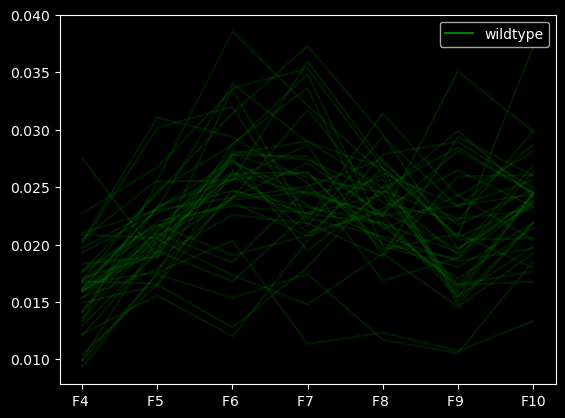

In [39]:
def plot_wt(wildtype_dictionary, mixture_to_analyze):
    fig, ax = plt.subplots()
    mixturevals = []
    for ind, gene in enumerate(wildtype_dictionary.keys()):
        # only plotting M1, if you would like to pick another mixture you may.
        mixturevals = (list(wildtype_dictionary[gene][mixture_to_analyze]))
        ax.plot(fractions, mixturevals, color = "green", alpha = 0.2)
    green_line = plt.Line2D([0], [0], color='green', label='wildtype')
    ax.legend(handles=[green_line])
    return
plot_wt(wildtype_dict, mixture_to_analyze)

In [56]:
def pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures):
    mut_dictionary = {}
    for gene in tqdm(genes):
        ind = newdf[newdf["Gene"] == gene].index
        gene_mixtures = {}
        for i in ind:
            if newdf["Genotype"][i] == wildtype:
                for mix in mixtures:
                    if newdf["Mixture"][i] == mix:
                        gene_biofractions = []
                        for frac in fractions:
                            val = newdf[(newdf["BioFraction"] == frac) & (newdf["Gene"] == gene) &
                                        (newdf["Genotype"] == mutant) & (newdf["Mixture"] == mix)]["Rel_Intensity"].values
                            gene_biofractions.extend(val)    
                        gene_mixtures[mix] = gene_biofractions
                mut_dictionary[gene] = gene_mixtures
    return mut_dictionary
mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)

100%|██████████| 60/60 [00:23<00:00,  2.54it/s]


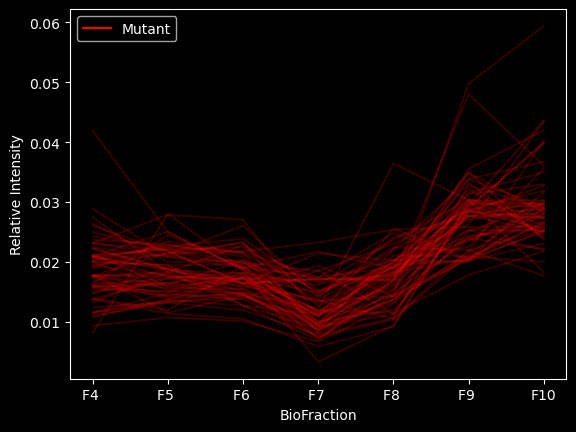

In [57]:
def plot_MUT(mut_dictionary, mixture_to_analyze):
    %matplotlib inline
    ax = plt.gca()
    mut_mixtures = []
    for gene in mut_dictionary.keys():
        # only plotting M1, if you would like to pick another mixture you may.
        mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
        ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.2)

    red_line = plt.Line2D([0], [0], color='red', label='Mutant')
    ax.legend(handles=[red_line])

    ax.set_xlabel("BioFraction")
    ax.set_ylabel("Relative Intensity") 
    plt.show()
    return
plot_MUT(mutant_dict, mixture_to_analyze)

In [58]:
## Function for scientific notation
def as_sn(number):
    formatted_number = "{:.2e}".format(number)
    formatted_number = formatted_number.replace('e', 'x10')
    exponent_start = formatted_number.index('x10') + len('x10')
    
    exponent = formatted_number[exponent_start:]
    if "-" in exponent:
        exponent = exponent.translate(str.maketrans('-0123456789', '⁻⁰¹²³⁴⁵⁶⁷⁸⁹'))
    else:
        exponent = exponent.translate(str.maketrans('+0123456789', '⁺⁰¹²³⁴⁵⁶⁷⁸⁹'))


    formatted_number = formatted_number[:exponent_start]  + exponent
    return formatted_number
form = as_sn(1.399393e22)
print(form)
print('4' + '\u2070' + '3')

1.40x10⁺²²
4⁰3


analyzing ONLY mixture M3
7 ###################
Directory 'SNCA_MixtureM3' created successfully.
SNCA_MixtureM3/SNCA_Module7_MixtureM3.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixtureM3/SNCA_Module7_MixtureM3.png


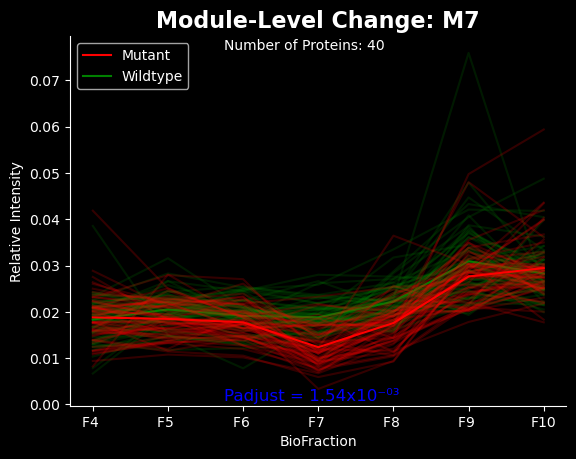

In [59]:
def plot_MUTWT_1mix(wt_dictionary, mut_dictionary, significant_module, pAdjustScore, nProts, mixture_to_analyze):
        ## both together
    fig, ax = plt.subplots()
    print(f"analyzing ONLY mixture {mixture_to_analyze}")
    WT = []
    if nProts < 50:
        for ind, gene in enumerate(wt_dictionary.keys()):
            # only plotting M1, if you would like to pick another mixture you may.
            wt_mixturevals = (list(wt_dictionary[gene][mixture_to_analyze]))
            WT.append((list(wt_dictionary[gene][mixture_to_analyze])))
            ax.plot(fractions, wt_mixturevals, color = "green", alpha = 0.2)
        WT_average = np.mean(WT, axis = 0)
        ax.plot(fractions, WT_average, color = "green")

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        ax.legend(handles=[green_line])
        Mut = []
        for gene in mut_dictionary.keys():
            # only plotting M1, if you would like to pick another mixture you may.
            mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
            Mut.append((list(mut_dictionary[gene][mixture_to_analyze])))
            ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.2)
        MUT_average = np.mean(Mut, axis = 0)
        ax.plot(fractions, MUT_average, color = "red")
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')
        ax.legend(handles=[red_line, green_line])

    elif 50 <= nProts <= 100:
        for ind, gene in enumerate(wt_dictionary.keys()):
            # only plotting M1, if you would like to pick another mixture you may.

            wt_mixturevals = (list(wt_dictionary[gene][mixture_to_analyze]))
            WT.append((list(wt_dictionary[gene][mixture_to_analyze])))
            ax.plot(fractions, wt_mixturevals, color = "green", alpha = 0.1)
        WT_average = np.mean(WT, axis = 0)


        ax.plot(fractions, WT_average, color = "green")

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        ax.legend(handles=[green_line])
        Mut = []
        for gene in mut_dictionary.keys():
            # only plotting M1, if you would like to pick another mixture you may.
            mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
            Mut.append((list(mut_dictionary[gene][mixture_to_analyze])))
            ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.1)
        MUT_average = np.mean(Mut, axis = 0)
        ax.plot(fractions, MUT_average, color = "red")
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')
        ax.legend(handles=[red_line, green_line])

    elif nProts >= 101:
        for ind, gene in enumerate(wt_dictionary.keys()):
            # only plotting M1, if you would like to pick another mixture you may.
            wt_mixturevals = (list(wt_dictionary[gene][mixture_to_analyze]))
            WT.append((list(wt_dictionary[gene][mixture_to_analyze])))
            ax.plot(fractions, wt_mixturevals, color = "green", alpha = 0.08)
        WT_average = np.mean(WT, axis = 0)
        ax.plot(fractions, WT_average, color = "green")

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        ax.legend(handles=[green_line])
        Mut = []
        for gene in mut_dictionary.keys():
            # only plotting M1, if you would like to pick another mixture you may.
            mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
            Mut.append((list(mut_dictionary[gene][mixture_to_analyze])))
            ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.08)
        MUT_average = np.mean(Mut, axis = 0)
        ax.plot(fractions, MUT_average, color = "red")
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')
        ax.legend(handles=[red_line, green_line])
    print(len(WT_average), "###################")

    directory = f"{gene_analyzing}_Mixture{mixture_to_analyze}"
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")
    plot_size_inches = fig.get_size_inches()

     # Get the current limits of the y-axis
    ymin, ymax = plt.ylim()

    # Retrieve the maximum value of the y-axis
    max_y = ymax
    min_y = ymin

    ax.set_xlabel("BioFraction")
    ax.set_ylabel("Relative Intensity")  ## FIXME -> needs to be normalized log2scale to be between 0-1
    ax.set_title(f"Module-Level Change: M{significant_module}", fontsize = 16, fontweight = "bold")
    plt.text(1.75 , ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='blue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize = 10)
    savefigure = f"{directory}/{gene_analyzing}_Module{significant_module}_Mixture{mixture_to_analyze}.png"
    plt.savefig(savefigure)
    if os.path.exists(savefigure):
        print(f"{savefigure} file created!\n"
             f"This is the filepath {os.path.abspath(savefigure)}")
    plt.show()
    return WT, Mut, mixture_to_analyze
WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, significant_module, pAdjustScore, nprots, mixture_to_analyze)

analyzing ALL mixtures: ['M1', 'M2', 'M3']
60 7
Directory 'SNCA_MixturesAveraged' already exists.
SNCA_MixturesAveraged/SNCA_Module5_MixturesAveraged.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixturesAveraged/SNCA_Module5_MixturesAveraged.png


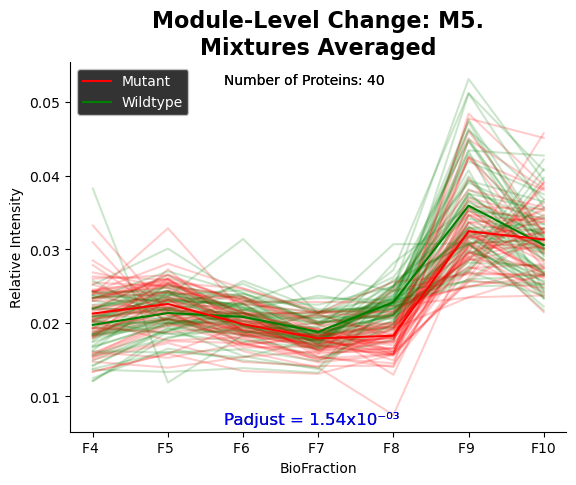

In [60]:
def find_avg_plots(wt_dictionary, mut_dictionary, significant_module, pAdjustScore, nProts, mixtures):
     ## both together
    print(f"analyzing ALL mixtures: {mixtures}")
    fig, ax = plt.subplots()
#     WT_lists = [[] for _ in range(mixtures)]
#     MUT_lists = [[] for _ in range(mixtures)]
    WT_all = []
    MUT_all = []
    for mix in mixtures:
        WT = []
        Mut = []
        for ind, gene in enumerate(wt_dictionary.keys()):
            # only plotting M1, if you would like to pick another mixture you may.
            WT.append((list(wt_dictionary[gene][mix])))
            Mut.append((list(mut_dictionary[gene][mix])))
        WT_all.append(WT)
        MUT_all.append(Mut)
    WT_average = np.mean(WT_all, axis = 0)
    MUT_average = np.mean(MUT_all, axis = 0)
    print(len(WT_average), len(WT_average[0]))
    WT_singular_average = np.mean(WT_average, axis = 0)
    MUT_singular_average = np.mean(MUT_average, axis = 0)

    if nProts <= 50:
        for ind, wtvals in enumerate(WT_average):
            ax.plot(fractions, wtvals, color = 'green', alpha = 0.2)
            ax.plot(fractions, MUT_average[ind], color = 'red', alpha =0.2)
        ax.plot(fractions, WT_singular_average, color = 'green')
        ax.plot(fractions, MUT_singular_average, color = 'red')

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')
        ax.legend(handles=[red_line, green_line])
    elif 50 < nProts <100:
        for ind, wtvals in enumerate(WT_average):
            ax.plot(fractions, wtvals, color = 'green', alpha = 0.1)
            ax.plot(fractions, MUT_average[ind], color = 'red', alpha =0.1)
        ax.plot(fractions, WT_singular_average, color = 'green')
        ax.plot(fractions, MUT_singular_average, color = 'red')

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')
    elif nProts >= 100:
        for ind, wtvals in enumerate(WT_average):
            ax.plot(fractions, wtvals, color = 'green', alpha = 0.08)
            ax.plot(fractions, MUT_average[ind], color = 'red', alpha =0.08)
        ax.plot(fractions, WT_singular_average, color = 'green')
        ax.plot(fractions, MUT_singular_average, color = 'red')

        green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
        red_line = plt.Line2D([0], [0], color='red', label='Mutant')

    directory = f"{gene_analyzing}_MixturesAveraged"
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")
    plot_size_inches = fig.get_size_inches()

     # Get the current limits of the y-axis
    ymin, ymax = plt.ylim()

    # Retrieve the maximum value of the y-axis
    max_y = ymax
    min_y = ymin
    ax.legend(handles=[red_line, green_line])

    ax.set_xlabel("BioFraction", color='black')
    ax.set_ylabel("Relative Intensity", color='black')  ## FIXME -> needs to be normalized log2scale to be between 0-1
    ax.set_facecolor('white')
    
    # Set the spine color to black
    for spine in ax.spines.values():
        spine.set_color('black')

    # Set the tick color to black
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

    plt.text(1.75, ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='black')
    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize=10, color='black')

    ax.set_title(f"Module-Level Change: M{significant_module}.\nMixtures Averaged", fontsize = 16, fontweight = "bold", color='black')
    plt.text(1.75 , ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='blue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize = 10, color='black')
    fig.patch.set_facecolor('white')  # Ensure the entire figure background is white
    savefigure = f"{directory}/{gene_analyzing}_Module{significant_module}_MixturesAveraged.png"
    plt.savefig(savefigure, facecolor='white', edgecolor='white', bbox_inches='tight')
    if os.path.exists(savefigure):
        print(f"{savefigure} file created!\n"
             f"This is the filepath {os.path.abspath(savefigure)}")
    plt.show()
    return 
find_avg_plots(wildtype_dict, mutant_dict, 5, pAdjustScore, nprots, mixtures)

#     return WT, Mut

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

modules to analyze [8, 6, 12, 11, 5, 4, 15, 7, 14, 13]
8
Mixture analyzing M3
Moving to next module 8 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M8: 38

PadjustScore for module M8: 3.630775577528712e-43

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


100%|██████████| 37/37 [00:14<00:00,  2.51it/s]


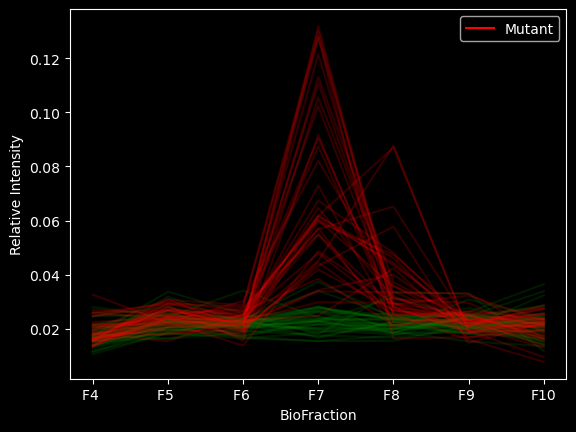

Averaging all mixtures, and creating plot of averages for module 8.
analyzing ALL mixtures: ['M1', 'M2', 'M3']
37 7
Directory 'SNCA_MixturesAveraged' already exists.
SNCA_MixturesAveraged/SNCA_Module8_MixturesAveraged.png file created!
This is the filepath /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/SNCA_MixturesAveraged/SNCA_Module8_MixturesAveraged.png


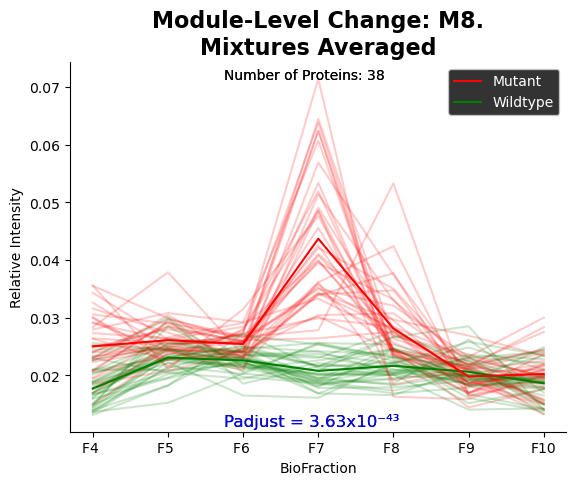

6
Mixture analyzing M3
Moving to next module 6 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M6: 57

PadjustScore for module M6: 1.564696829072403e-12

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


 41%|████      | 20/49 [00:08<00:12,  2.41it/s]


KeyboardInterrupt: 

In [89]:
import re
def main():
    global mixture_to_analyze, gene_analyzing, foldername, currentdir, abspath, transformedfile, module_results_file
    global wildtype, mutant, proteins, fractions, genes, mixtures

    average_mixtures = True  # True to average all mixtures
    mixture_to_analyze = "M3"  # Specify mixture; ignored if averaging
    significant_module = None  # None to analyze all modules

    # Common initial steps
    geneAnalysis, transformeddatadf, partition_df = gene_file_to_analyze(gene_analyzing, transformedfile, module_results_file)
    alldata_df = merge_dataframes(transformeddatadf, partition_df)
    newdf = drop_irrelevant_cols(alldata_df)

    # Determine modules to analyze
    module_details_df, nprots, pAdjustScore, sigmodules = pick_module(None)
    sigmodules = [int(re.search(r'\d+', element).group()) for element in sigmodules if re.search(r'\d+', element)]
    print("modules to analyze", sigmodules)
    for module in sigmodules:
        print(module)
        print(f"Mixture analyzing {mixture_to_analyze}")
        print(f"Moving to next module {module} \n")
        module_details_df, nprots, pAdjustScore, sigmodules = pick_module(module)
        proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, module)
        wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)
        plot_wt(wildtype_dict, mixture_to_analyze)
        mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)
        plot_MUT(mutant_dict, mixture_to_analyze)

        if average_mixtures:
            print(f"Averaging all mixtures, and creating plot of averages for module {module}.")
            find_avg_plots(wildtype_dict, mutant_dict, module, pAdjustScore, nprots, mixtures)
        else:
            print(f"Plotting only mixture {mixture_to_analyze} for module {module}.")
            WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, module, pAdjustScore, nprots, mixture_to_analyze)

    return

main()

In [84]:
# def main():
#     global mixture_to_analyze
#     global gene_analyzing
#     global foldername
#     global currentdir
#     global abspath
#     global transformedfile
#     global module_results_file
#     global wildtype
#     global mutant
#     global proteins
#     global fractions
#     global genes
#     global mixtures


#     ## Would you like to analyze a singular mixture or average all mixtures?
#     average_mixtures = True
#     mixture_to_analyze = "M3" # Put a mixture here, but if you said True above for the averaging, it will average
#     ## FIXME: Not averaging three mixutres yet- might be a necessity
#     # Please specify which module you would like to analyze. If you would lke to analyze all, leave this as None and allow the for loop in main 
#     # to proceed.
#     significant_module = None ## None if you want to run loop for all.

#     if significant_module is not None:
#         print(f"analyzing module {significant_module}")
#         geneAnalysis, transforrmeddatadf, partition_df = gene_file_to_analyze(gene_analyzing, transformedfile, module_results_file)
#         alldata_df = merge_dataframes(transforrmeddatadf, partition_df)
#         newdf = drop_irrelevant_cols(alldata_df)
#         module_details_df, nprots, pAdjustScore = pick_module(significant_module)
#         proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, significant_module)
#         wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)
#         plot_wt(wildtype_dict, mixture_to_analyze)
#         mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)
#         plot_MUT(mutant_dict, mixture_to_analyze)
#         if average_mixtures == True:
#             print(f"Averaging all mixtures, and creating plot of averages for module {significant_module}.")
#             find_avg_plots(wildtype_dict, mutant_dict, significant_module, pAdjustScore, nprots, mixtures)
#         else:
#             print(f"Plotting only mixture {mixture_to_analyze} for module {significant_module}")
#             WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, significant_module, pAdjustScore, nprots, mixture_to_analyze)
#     else:
#         geneAnalysis, transforrmeddatadf, partition_df = gene_file_to_analyze(gene_analyzing, foldername, transformedfile, module_results_file)
#         alldata_df = merge_dataframes(transforrmeddatadf, partition_df)
#         newdf = drop_irrelevant_cols(alldata_df)
#         module_details_df, nprots, pAdjustScore = pick_module(significant_module)
#         allmodules = module_details_df["Module"].values
#         print(f"Total Modules: {len(allmodules)}")
#         sigmodules = module_details_df[module_details_df["candidate"] == True]["Module"].values
#         for module in (sigmodules): # change to allmodules if you need to// for module in range(1, len(allmodules)):
#             print(f"Mixture analyzing {mixture_to_analyze}")
#             significant_module = module
#             print(f"Moving to next module {significant_module} \n")
#             module_details_df, nprots, pAdjustScore = pick_module(significant_module)
#             proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, significant_module)
#             wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)
#             plot_wt(wildtype_dict, mixture_to_analyze)
#             mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)
#             plot_MUT(mutant_dict, mixture_to_analyze)
#             if average_mixtures == True:
#                 print(f"Averaging all mixtures, and creating plot of averages for module {module} currently.")
#                 find_avg_plots(wildtype_dict, mutant_dict, significant_module, pAdjustScore, nprots, mixtures)
#             else:
#                 print(f"Plotting only mixture {mixture_to_analyze} for module {module} currently.")
#                 WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, significant_module, pAdjustScore, nprots, mixture_to_analyze)
#     return

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

modules to analyze ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']
Mixture analyzing M3
Moving to next module M8 

Significant Modules in this dataset: ['M8' 'M6' 'M12' 'M11' 'M5' 'M4' 'M15' 'M7' 'M14' 'M13']

Number of proteins in module M8: 38

PadjustScore for module M8: 3.630775577528712e-43

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


0it [00:00, ?it/s]
0it [00:00, ?it/s]


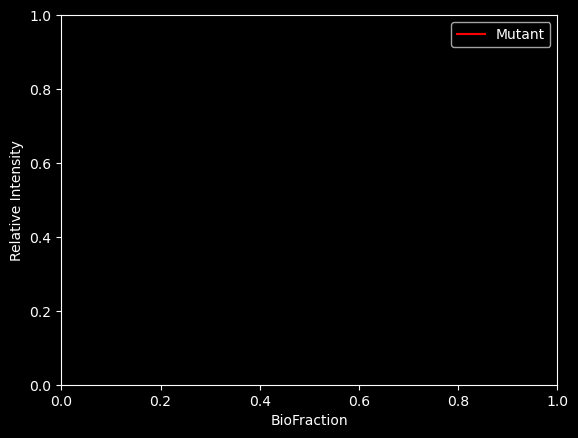

Averaging all mixtures, and creating plot of averages for module M8.
analyzing ALL mixtures: []


/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/poojaparameswaran/anaconda3/envs/dataenv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()

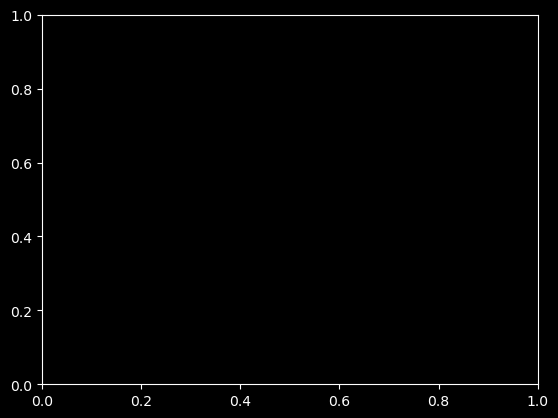

In [85]:
if __name__ == "__main__":

    main()